In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/deep_learning
!pip install cptac==1.1.0

/content/drive/MyDrive/deep_learning


In [3]:
import tokens_data as t
import models as m
import get_data as get_data
import train_predict

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm


from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Data Collection and Cleaning

In [4]:
data = get_data.data_collection()
data.download_data()
data.load_data()
data.combine_data(individual = True)

all_transcriptome_data = data.transcriptome
all_proteome_data = data.proteome

cptac warning: Your version of cptac (1.1.0) is out-of-date. Latest is 1.5.14. Please run 'pip install --upgrade cptac' to update it. (/usr/lib/python3.10/threading.py, line 953)


All datasets have been downloaded.
Loading CPTAC datasets into memory...


/usr/local/lib/python3.10/dist-packages/cptac/ovarian.py:148: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(nan_equivalents, np.nan)


All datasets have been loaded.
Combining transcriptomics and proteomics data...


# Model Training

In [5]:
device = data.device

In [6]:
common_samples = all_transcriptome_data.index.intersection(all_proteome_data.index)
all_transcriptome_data = all_transcriptome_data.loc[common_samples]
all_proteome_data = all_proteome_data.loc[common_samples]

all_transcriptome_data = all_transcriptome_data.fillna(0)
all_proteome_data = all_proteome_data.fillna(0)

all_transcriptome_data = all_transcriptome_data.drop('Cancer', axis = 1)
all_proteome_data = all_proteome_data.drop('Cancer', axis = 1)

gene_array = all_transcriptome_data.astype(float).to_numpy()
protein_array = all_proteome_data.astype(float).to_numpy()

gene_tensor = torch.tensor(gene_array, dtype=torch.float32)
protein_tensor = torch.tensor(protein_array, dtype=torch.float32)

num_samples, num_genes = gene_tensor.shape
num_samples, num_proteins = protein_tensor.shape

embedding_dim = 128

gene_embedding = nn.Embedding(num_genes, embedding_dim)
protein_embedding = nn.Embedding(num_proteins, embedding_dim)
value_encoder = nn.Linear(1, embedding_dim)

labels_tensor = data.labels

<ipython-input-6-45d66b2fe7d2>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_transcriptome_data = all_transcriptome_data.fillna(0)
<ipython-input-6-45d66b2fe7d2>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_proteome_data = all_proteome_data.fillna(0)


In [7]:
train_indices, val_indices = train_test_split(list(range(num_samples)), test_size=0.3, random_state=42)
train_gene_data = gene_array[train_indices]
train_protein_data = protein_array[train_indices]
train_labels = labels_tensor[train_indices]

val_gene_data = gene_array[val_indices]
val_protein_data = protein_array[val_indices]
val_labels = labels_tensor[val_indices]

In [9]:
train_dataset = t.omics_dataset(train_gene_data, train_protein_data, train_labels, gene_embedding, protein_embedding, value_encoder)
val_dataset = t.omics_dataset(val_gene_data, val_protein_data, val_labels, gene_embedding, protein_embedding, value_encoder)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
model = m.omics_transformer(128, len(data.cancer_labels)).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5000

train_loss, val_loss = train_predict.train_model(model, train_loader, val_loader, loss, optimizer, num_epochs)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Training Progress:   0%|          | 0/5000 [00:00<?, ?epoch/s]


Training


Training Progress:   0%|          | 0/5000 [03:10<?, ?epoch/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.54 GiB. GPU 0 has a total capacity of 14.75 GiB of which 39.06 MiB is free. Process 68469 has 14.71 GiB memory in use. Of the allocated memory 13.51 GiB is allocated by PyTorch, and 1.08 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
pred_labels, true_labels, accuracy = train_predict.get_predictions(model, val_loader, device, data.label_to_id, accuracy = True)
print(f'Model Accuracy: {accuracy}')

# Previous Attempts

In [6]:
data.combine_data()
data.clean_data()

X = data.all_data_cleaned.drop('Cancer', axis=1)
y = data.all_data_cleaned['Cancer']


selected_columns = random.sample(list(X.columns), 4000)
X_sample = X[selected_columns]

X_train, X_val, y_train, y_val = train_test_split(X_sample, y, test_size=0.2, random_state=42)

Combining transcriptomics and proteomics data...
Data has been combined into a single DataFrame.


In [7]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_val.shape)

# Check class balance in the target variable
print("y_train distribution:")
print(y_train.value_counts())

print("y_test distribution:")
print(y_val.value_counts())

X_train shape: (872, 4000)
X_test shape: (219, 4000)
y_train shape: (872,)
y_test shape: (219,)
y_train distribution:
Cancer
Lung             166
Renal Cell       161
Head and Neck    146
Endometrial      120
Ovarian          102
Breast            92
Brain             85
Name: count, dtype: int64
y_test distribution:
Cancer
Lung             45
Head and Neck    43
Renal Cell       33
Breast           30
Endometrial      24
Brain            24
Ovarian          20
Name: count, dtype: int64


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.values)
y_val_encoded = label_encoder.transform(y_val.values)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long).to(device)

In [9]:
num_features = X_train_tensor.shape[1]
hidden_size = 128
num_classes = len(torch.unique(y_train_tensor))

model = m.cancer_transformer(num_features, hidden_size, num_classes).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_tensor.cpu().numpy()), y=y_train_tensor.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)


loss = nn.CrossEntropyLoss(weight = class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5000
batch_size = 128

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
latent_dim = 64
auto_loss = nn.MSELoss()
autoencoder_model = m.autoencoder(num_features, latent_dim).to(device)
auto_optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [12]:
train_auto, val_auto = train_predict.train_autoencoder(autoencoder_model, train_loader, val_loader, auto_loss, auto_optimizer, num_epochs)

Training Progress: 100%|██████████| 5000/5000 [03:00<00:00, 27.70epoch/s]


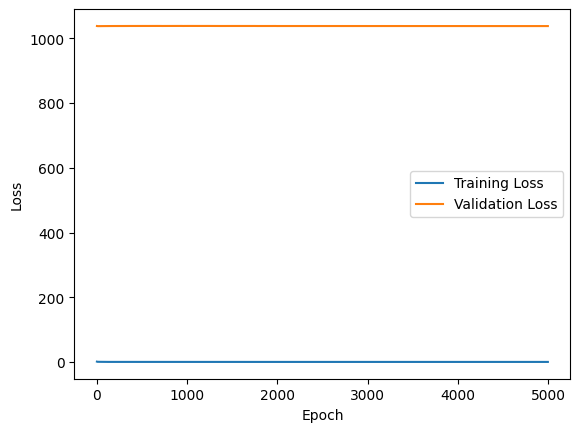

In [13]:
plt.plot(train_auto, label='Training Loss')
plt.plot(val_auto, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
X_train_latent = autoencoder_model.encoder(X_train_tensor.to(device)).detach().cpu().numpy()
X_val_latent = autoencoder_model.encoder(X_val_tensor.to(device)).detach().cpu().numpy()

new_train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_latent, dtype=torch.float32), y_train_tensor)
new_val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_latent, dtype=torch.float32), y_val_tensor)

new_train_loader = torch.utils.data.DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
new_val_loader = torch.utils.data.DataLoader(new_val_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(torch.unique(y_train_tensor))
model = m.cancer_mlp(latent_dim, hidden_size, num_classes).to(device)

In [15]:
train_losses, val_losses = train_predict.old_train_model(model, new_train_loader, new_val_loader, loss, optimizer, num_epochs)

Training Progress: 100%|██████████| 5000/5000 [00:26<00:00, 189.89epoch/s]


In [17]:
y_pred_classes = train_predict.old_get_predictions(model, X_val_latent, device)
y_true = y_val_tensor.cpu().numpy()
y_true_labels = label_encoder.inverse_transform(y_true)


In [18]:
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_pred_labels

array(['Breast', 'Breast', 'Endometrial', 'Renal Cell', 'Breast',
       'Endometrial', 'Endometrial', 'Breast', 'Breast', 'Breast',
       'Endometrial', 'Renal Cell', 'Breast', 'Breast', 'Breast',
       'Renal Cell', 'Renal Cell', 'Renal Cell', 'Breast', 'Endometrial',
       'Endometrial', 'Breast', 'Renal Cell', 'Endometrial', 'Breast',
       'Endometrial', 'Endometrial', 'Endometrial', 'Breast',
       'Endometrial', 'Breast', 'Breast', 'Breast', 'Endometrial',
       'Breast', 'Breast', 'Renal Cell', 'Endometrial', 'Breast',
       'Head and Neck', 'Endometrial', 'Breast', 'Endometrial',
       'Endometrial', 'Breast', 'Endometrial', 'Breast', 'Breast',
       'Endometrial', 'Endometrial', 'Breast', 'Renal Cell', 'Renal Cell',
       'Renal Cell', 'Breast', 'Breast', 'Endometrial', 'Breast',
       'Endometrial', 'Endometrial', 'Endometrial', 'Breast', 'Breast',
       'Breast', 'Breast', 'Endometrial', 'Breast', 'Breast', 'Breast',
       'Breast', 'Endometrial', 'Renal Cell',

In [19]:
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

Accuracy: 0.1187214611872146
               precision    recall  f1-score   support

        Brain       0.00      0.00      0.00        24
       Breast       0.13      0.43      0.20        30
  Endometrial       0.14      0.54      0.23        24
Head and Neck       0.00      0.00      0.00        43
         Lung       0.00      0.00      0.00        45
      Ovarian       0.00      0.00      0.00        20
   Renal Cell       0.00      0.00      0.00        33

     accuracy                           0.12       219
    macro avg       0.04      0.14      0.06       219
 weighted avg       0.03      0.12      0.05       219



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
y_true_labels

array(['Renal Cell', 'Renal Cell', 'Endometrial', 'Endometrial',
       'Renal Cell', 'Breast', 'Head and Neck', 'Lung', 'Breast',
       'Renal Cell', 'Lung', 'Brain', 'Renal Cell', 'Lung', 'Breast',
       'Brain', 'Brain', 'Lung', 'Ovarian', 'Breast', 'Breast', 'Ovarian',
       'Endometrial', 'Lung', 'Renal Cell', 'Breast', 'Breast', 'Lung',
       'Renal Cell', 'Head and Neck', 'Lung', 'Lung', 'Lung',
       'Head and Neck', 'Ovarian', 'Ovarian', 'Endometrial',
       'Head and Neck', 'Renal Cell', 'Brain', 'Head and Neck', 'Breast',
       'Lung', 'Endometrial', 'Renal Cell', 'Head and Neck', 'Lung',
       'Breast', 'Lung', 'Lung', 'Brain', 'Ovarian', 'Brain', 'Lung',
       'Brain', 'Ovarian', 'Head and Neck', 'Breast', 'Endometrial',
       'Lung', 'Endometrial', 'Lung', 'Renal Cell', 'Head and Neck',
       'Breast', 'Head and Neck', 'Brain', 'Brain', 'Breast', 'Lung',
       'Head and Neck', 'Ovarian', 'Endometrial', 'Renal Cell',
       'Renal Cell', 'Endometrial', 'Renal C

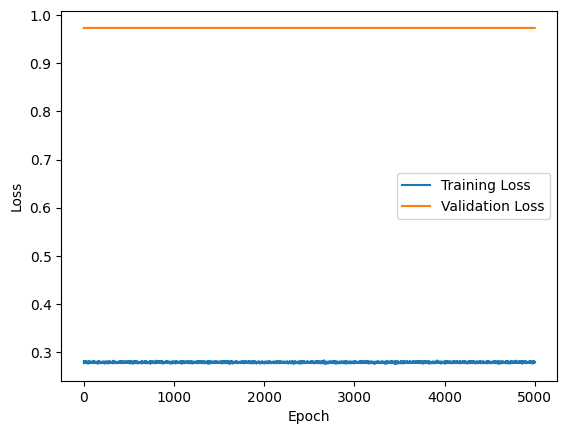

In [21]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()